# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [1]:
# If on colab, uncomment the following lines

#! curl -O https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

---
### Технический блок функций и классов

In [ ]:
# Функция для отсечения выбросов
def outliers_z_score(data, feature, left_mod=3, right_mod=3, log_scale=False):

    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]

    mu = x.mean()

    sigma = x.std()

    lower_bound = mu - left_mod * sigma

    upper_bound = mu + right_mod * sigma

    outliers = data[(x < lower_bound) | (x > upper_bound)]

    cleaned = data[(x > lower_bound) & (x < upper_bound)]

    return  cleaned

---
### Первичное исследование данных

In [2]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

# Преобразуем датасет к датафрейму
data_df = pd.DataFrame(data)
target_df = pd.DataFrame(target)

print("Обучающая выборка:")
display(data_df.head())

print("Таргет выборка:")
display(target_df.head())

(846, 19) (846,)
Обучающая выборка:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197
1,1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199
2,2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196
3,3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207
4,4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183


Таргет выборка:


,0
0,van
1,van
2,saab
3,van
4,bus


In [3]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,422.500000,93.678487,44.861702,82.088652,168.940898,61.693853,8.567376,168.839243,40.933806,20.582742,147.998818,188.625296,439.911348,174.70331,72.462175,6.377069,12.599291,188.932624,195.632388
std,244.363459,8.234474,6.169866,15.771533,33.472183,7.888251,4.601217,33.244978,7.811560,2.592138,14.515652,31.394837,176.692614,32.54649,7.486974,4.918353,8.931240,6.163949,7.438797
min,0.000000,73.000000,33.000000,40.000000,104.000000,47.000000,2.000000,112.000000,26.000000,17.000000,118.000000,130.000000,184.000000,109.00000,59.000000,0.000000,0.000000,176.000000,181.000000
25%,211.250000,87.000000,40.000000,70.000000,141.000000,57.000000,7.000000,146.250000,33.000000,19.000000,137.000000,167.000000,318.250000,149.00000,67.000000,2.000000,5.000000,184.000000,190.250000
50%,422.500000,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.500000,364.000000,173.00000,71.500000,6.000000,11.000000,188.000000,197.000000
75%,633.750000,100.000000,49.000000,98.000000,195.000000,65.000000,10.000000,198.000000,46.000000,23.000000,159.000000,217.000000,587.000000,198.00000,75.000000,9.000000,19.000000,193.000000,201.000000
max,845.000000,119.000000,59.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.00000,135.000000,22.000000,41.000000,206.000000,211.000000


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       846 non-null    int64
 1   1       846 non-null    int64
 2   2       846 non-null    int64
 3   3       846 non-null    int64
 4   4       846 non-null    int64
 5   5       846 non-null    int64
 6   6       846 non-null    int64
 7   7       846 non-null    int64
 8   8       846 non-null    int64
 9   9       846 non-null    int64
 10  10      846 non-null    int64
 11  11      846 non-null    int64
 12  12      846 non-null    int64
 13  13      846 non-null    int64
 14  14      846 non-null    int64
 15  15      846 non-null    int64
 16  16      846 non-null    int64
 17  17      846 non-null    int64
 18  18      846 non-null    int64
dtypes: int64(19)
memory usage: 125.7 KB


> Все данные имеют числовой формат и судя по-всему 0 фит это индекс, дропнем его.

In [5]:
data_df = data_df.drop(columns=0)

In [6]:
# Проверим наличие пропусков в данных
data_df.isnull().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

> Пропусков нет

In [7]:
data_df[data_df.duplicated()]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18


> Дублей нет

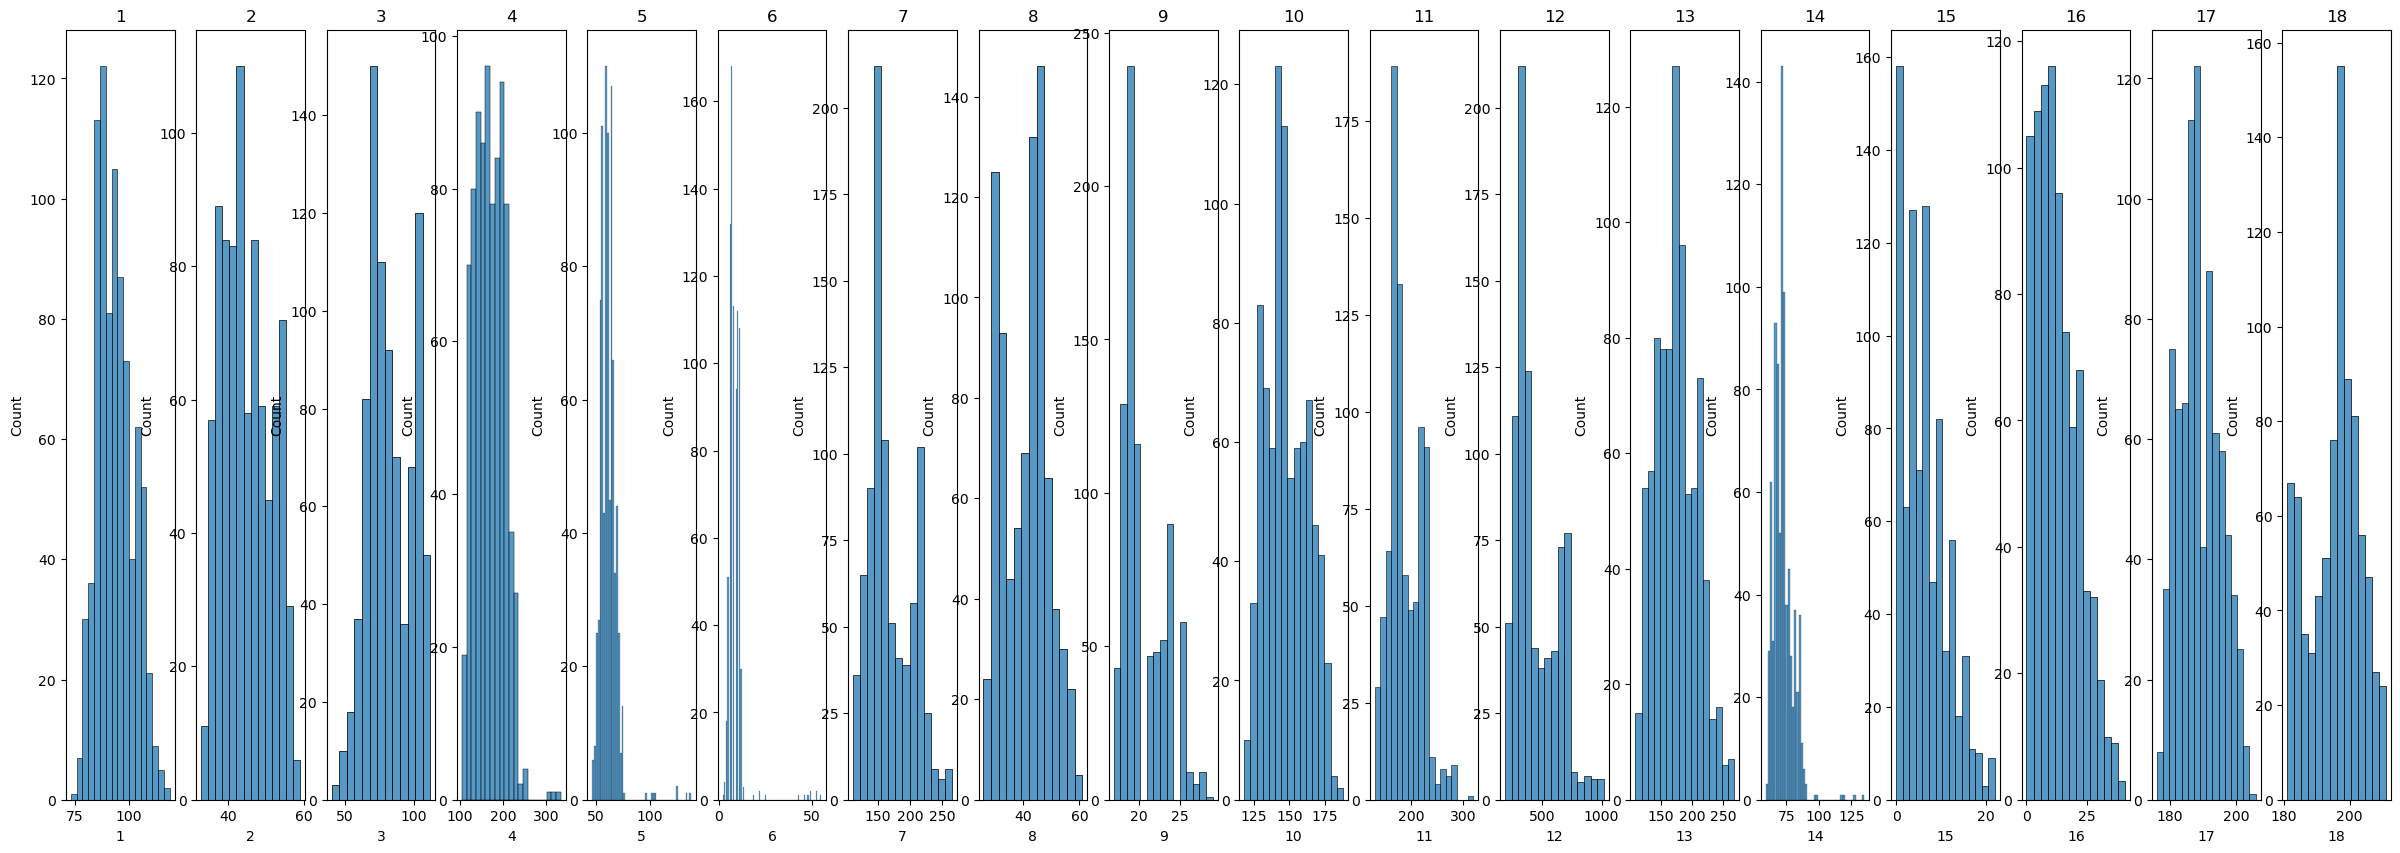

In [8]:
num_columns = len(data_df.columns)

# Создание подграфиков
fig, axes = plt.subplots(1, num_columns, figsize=(30, 10))

# Обход всех колонок и построение боксплота для каждой из них
for i, column in enumerate(data_df.columns):
    sns.histplot(data=data_df[column], ax=axes[i])
    axes[i].set_title(column)

# Отображение графиков
# plt.tight_layout()
plt.show()

> Признаки явно приходят из различных распределений. Часть признаков имеют явную мультимодальность и, вероятно, логнормальное распределение, следовательно лонарифмирование признаков может привести их распределение ближе к нормальному.


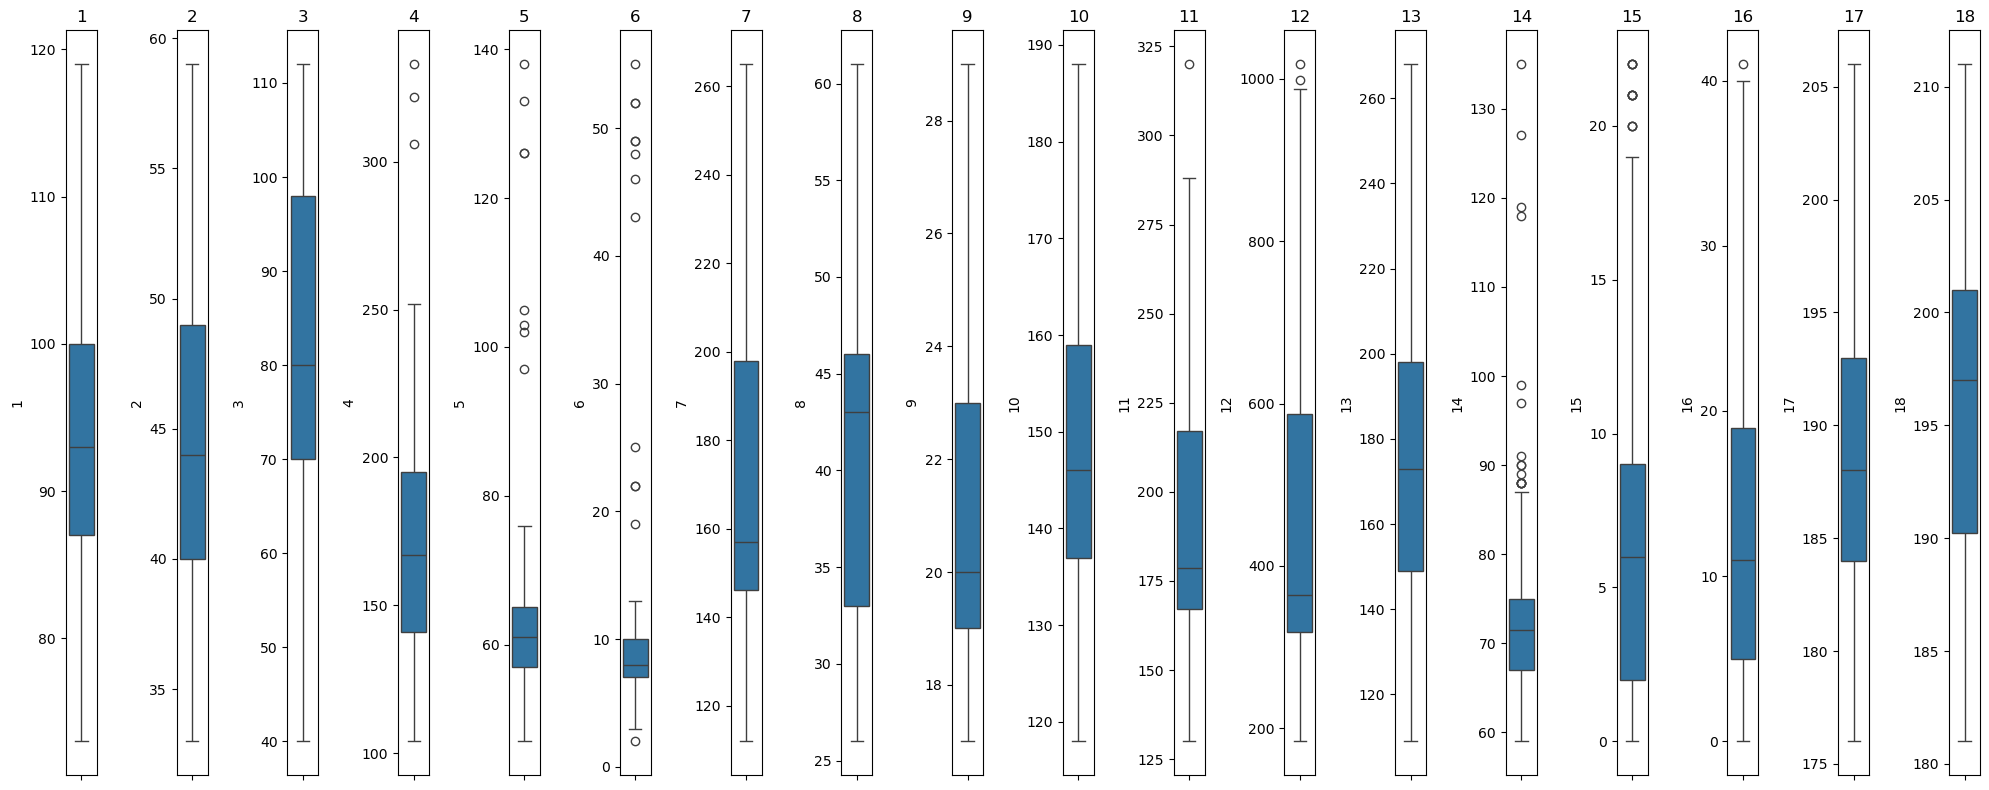

In [9]:
# Создание подграфиков
fig, axes = plt.subplots(1, num_columns, figsize=(20, 8))

# Обход всех колонок и построение боксплота для каждой из них
for i, column in enumerate(data_df.columns):
    sns.boxplot(data=data_df[column], ax=axes[i])
    axes[i].set_title(column)

# Отображение графиков
plt.tight_layout()
plt.show()

> По ряду признаков существует вероятность наличия выбросов. Нужно проверить их наличие после процедуры логарифмирования.

In [10]:
# Закодируем таргет
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target_df)
y_target = pd.DataFrame(y, columns=["target"])
y_target.value_counts()

target
0         218
2         217
1         212
3         199
Name: count, dtype: int64

> Классы сбалансированы

In [12]:
# Склеим датасет для очистки выбросов
data = pd.concat([data_df, y_target], axis=1)

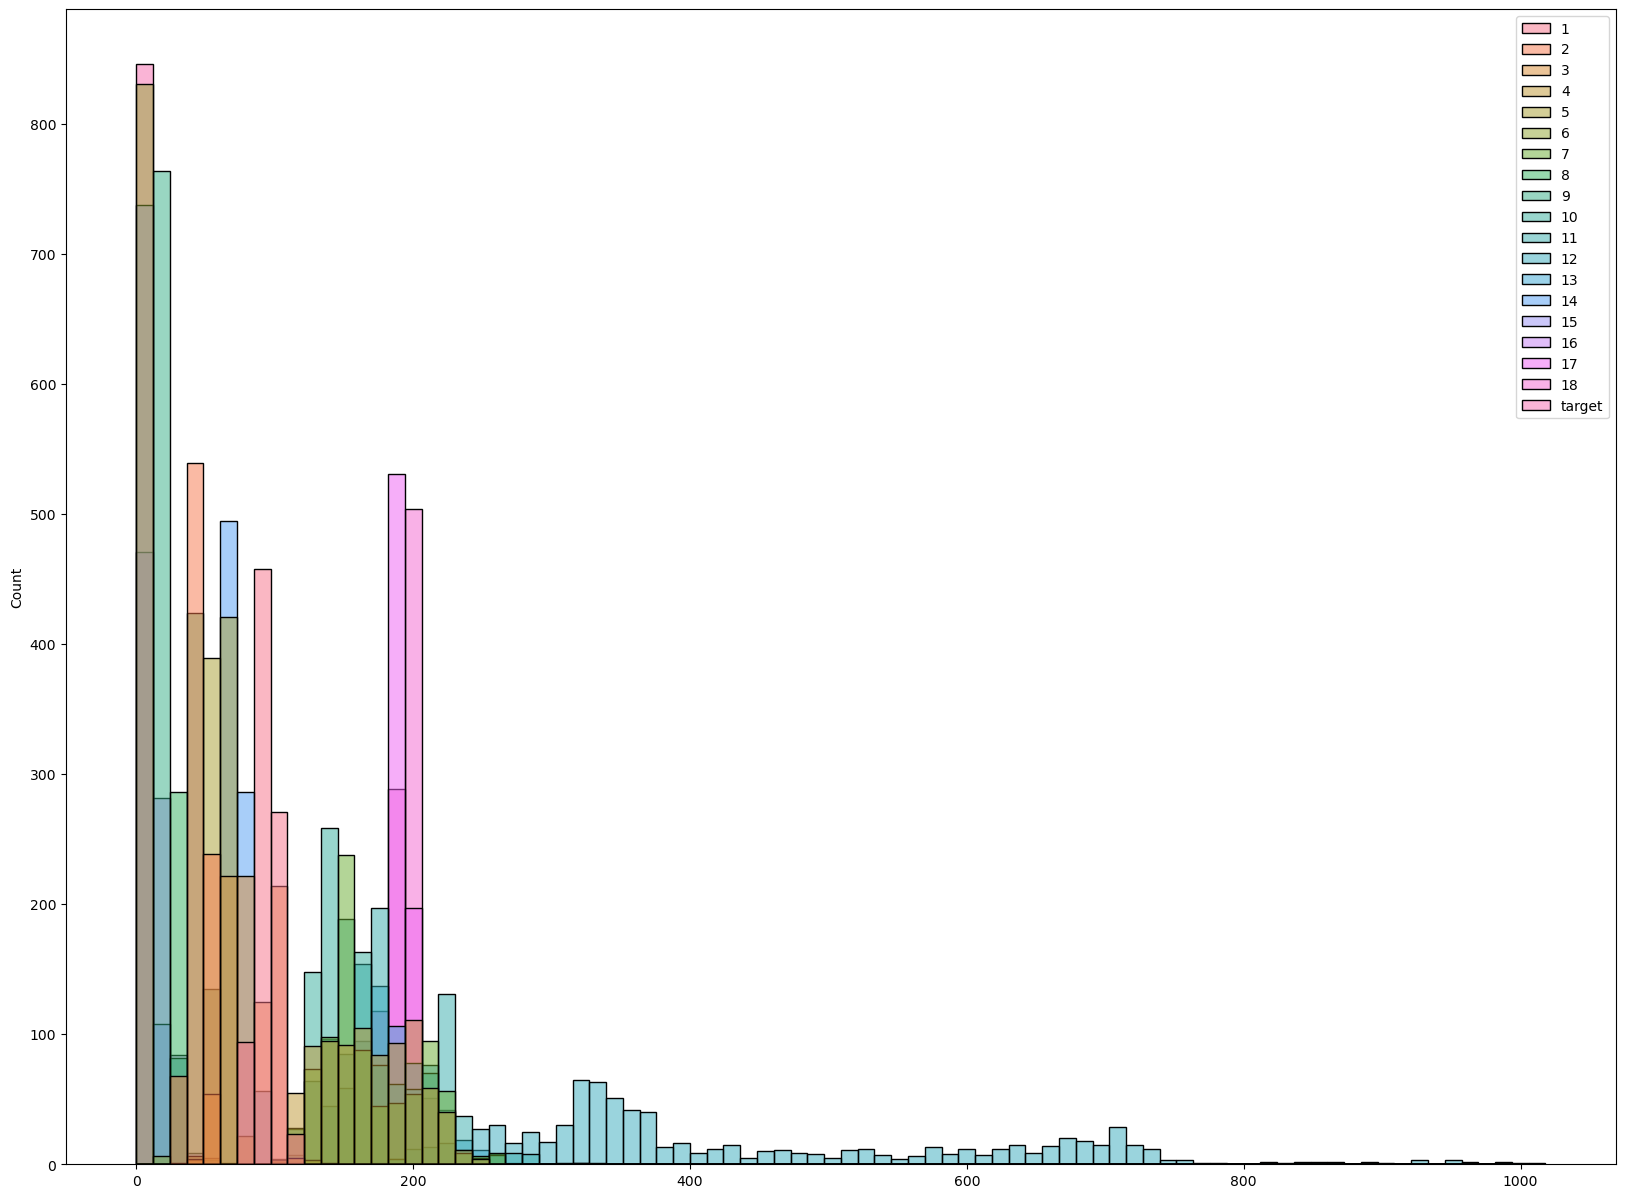

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.histplot(data=data, ax=axes)
plt.show()

> Можно наблюдать различие масштабов признаков - требуется нормальнизация.

### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.

#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations

In [17]:
# Опять разведем таргет и фиты для логарифмирования
X = data.drop(columns=['target'])
y = data['target']

In [18]:
# Придется создать класс логтрасформера для включения в пайплайн (если вдруг будем включать в пайп)
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transf = X.copy()
        # прикольный метод завместо np.log(x+1)
        X_transf = np.log1p(X_transf)
        return X_transf

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [19]:
log_transformer = LogTransformer()

data_df_log = X.copy()

data_df_log = log_transformer.fit_transform(X)

data_df_log.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.564348,3.891820,4.430817,5.187386,4.290459,2.397895,5.093750,3.761200,3.044522,5.075174,5.176150,5.940171,5.220356,4.262680,1.945910,2.833213,5.236442,5.288267
1,4.521789,3.737670,4.442651,4.955827,4.060443,2.302585,5.010635,3.828641,2.995732,4.969813,5.141664,5.802118,5.068904,4.290459,2.302585,2.708050,5.247024,5.298317
2,4.653960,3.931826,4.672829,5.347108,4.204693,2.397895,5.337538,3.496508,3.178054,5.068904,5.411646,6.455199,5.398163,4.304065,2.708050,2.302585,5.241747,5.283204
3,4.543295,3.737670,4.418841,5.075174,4.158883,2.302585,4.976734,3.850148,2.995732,4.969813,5.081404,5.736572,4.852030,4.158883,1.945910,2.397895,5.298317,5.337538
4,4.454347,3.806662,4.262680,5.327876,4.644391,3.970292,5.010635,3.828641,2.995732,4.976734,5.488938,5.786897,5.241747,4.852030,2.302585,2.484907,5.198497,5.214936


In [20]:
data_df_log = pd.concat([data_df_log, y], axis=1)
data_df_log.shape
display(data_df_log.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,target
0,4.564348,3.891820,4.430817,5.187386,4.290459,2.397895,5.093750,3.761200,3.044522,5.075174,5.176150,5.940171,5.220356,4.262680,1.945910,2.833213,5.236442,5.288267,3
1,4.521789,3.737670,4.442651,4.955827,4.060443,2.302585,5.010635,3.828641,2.995732,4.969813,5.141664,5.802118,5.068904,4.290459,2.302585,2.708050,5.247024,5.298317,3
2,4.653960,3.931826,4.672829,5.347108,4.204693,2.397895,5.337538,3.496508,3.178054,5.068904,5.411646,6.455199,5.398163,4.304065,2.708050,2.302585,5.241747,5.283204,2
3,4.543295,3.737670,4.418841,5.075174,4.158883,2.302585,4.976734,3.850148,2.995732,4.969813,5.081404,5.736572,4.852030,4.158883,1.945910,2.397895,5.298317,5.337538,3
4,4.454347,3.806662,4.262680,5.327876,4.644391,3.970292,5.010635,3.828641,2.995732,4.976734,5.488938,5.786897,5.241747,4.852030,2.302585,2.484907,5.198497,5.214936,0


Выведем графики для понимания как сработало логарифмирование на признаки

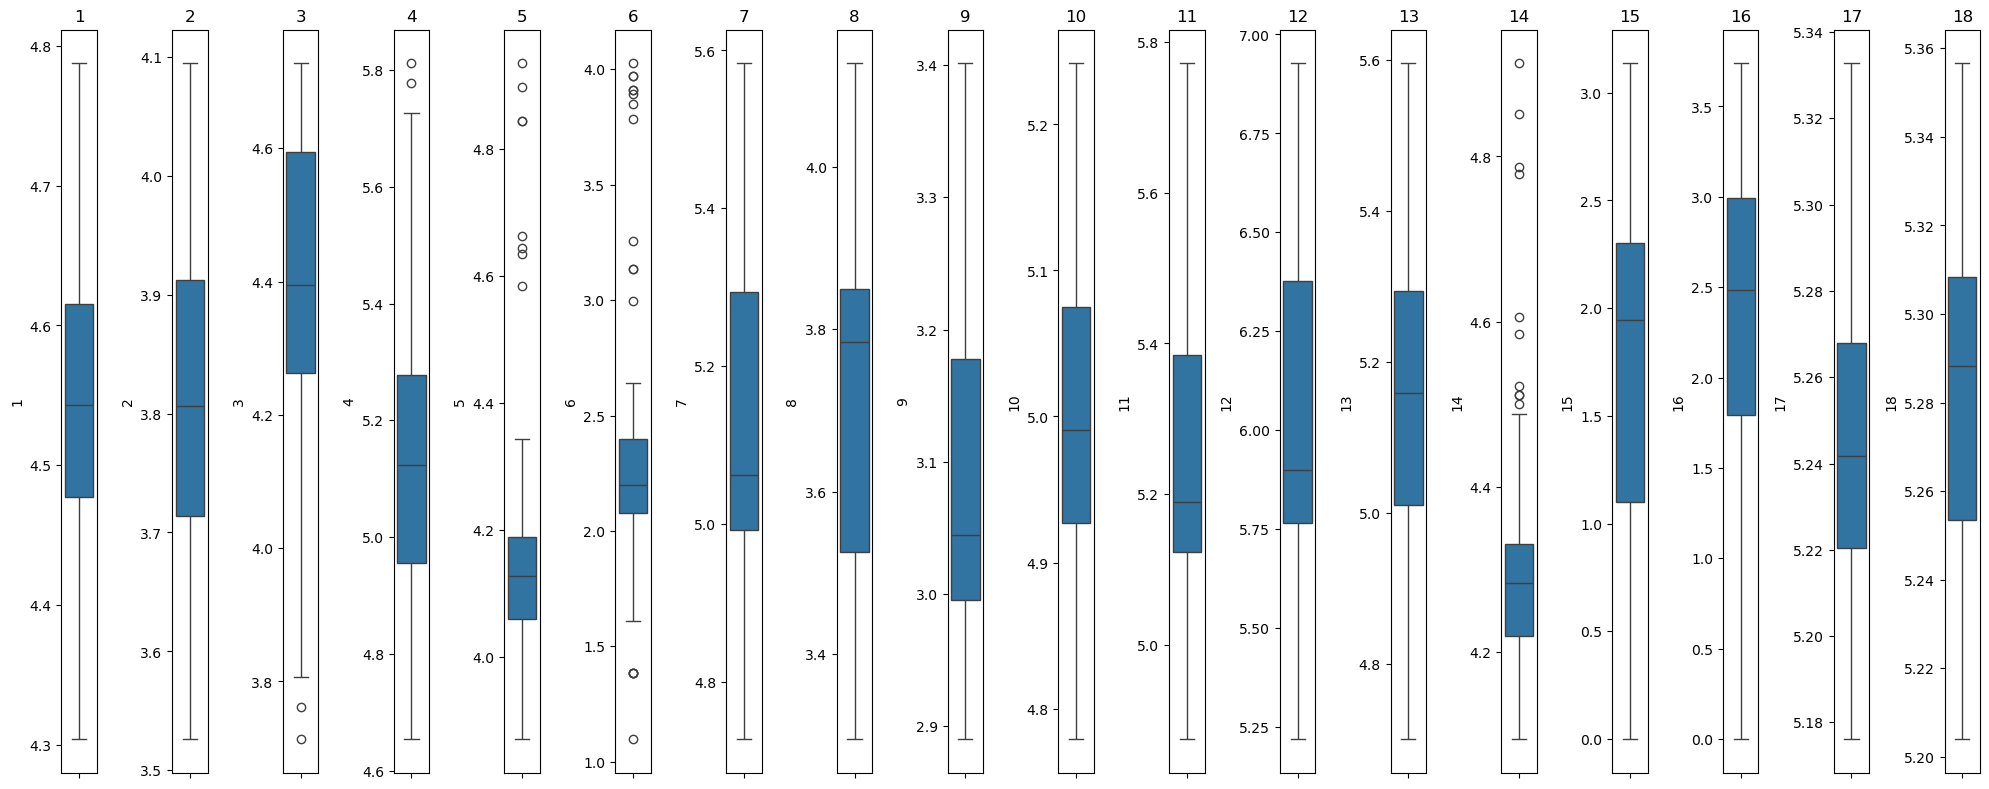

In [21]:
# Создание подграфиков
fig, axes = plt.subplots(1, num_columns, figsize=(20, 8))

# Обход всех колонок и построение боксплота для каждой из них
for i, column in enumerate(data_df_log.columns[:-1]):
    sns.boxplot(data=data_df_log[column], ax=axes[i])
    axes[i].set_title(column)

# Отображение графиков
plt.tight_layout()
plt.show()

> Можно наблюдать снижение количества признаков по которым вероятно существуют выбросы, в частности в признаках 4, 5, 6, 14. Так как у нас нет интерпретации их значений (возможно это не выбросы а характерные аномалии), и после логарифмирования мы снизили масштаб признакового пространства (что снизит влияние выбросов), то для base-line модели я решил не чистить эти фичи.

In [22]:
data_df_log.shape

(846, 19)

Проведем анализ на мультиколлинеарность признаков и влияние на таргет, для последующих этапов.

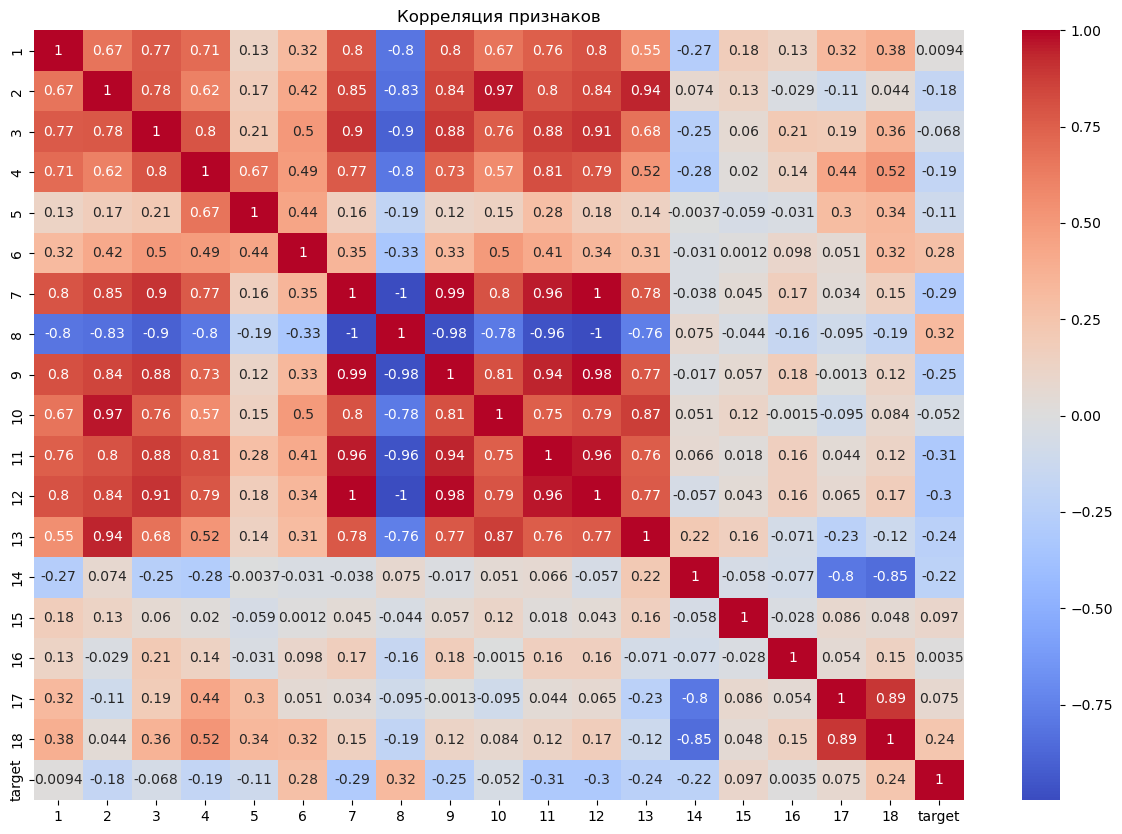

In [23]:
# Создадим комбинированный датафрейм
# heat_df = pd.concat([data_df_log, y_target], axis=1)

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(data_df_log.corr(), annot=True, ax=axes, cmap='coolwarm')
plt.title("Корреляция признаков")
plt.show()

> Корреляция на таргет у признаков не высокая, а вот мультиколлинеарность заметная, что говорит о том, что в простейщем варианте можно было бы дропать фиты, но так как в дальнейших заданиях у нас имеется метод главных компонент, выявим подмножество/ва признаков для этапа PCA.

> За отсечку примем значение по модулю 0.8, но сначала удалим фиты с корреляцией равной 0.95-1 исходя из принципа меньшего влияния на таргет.



In [24]:
# data_df_log_cleaned = data_df_log.drop(columns=[9, 7, 12, 8, 10])

In [25]:
# # Проверим результат
# fig, axes = plt.subplots(1, 1, figsize=(15, 10))
# sns.heatmap(data_df_log_cleaned.corr(), annot=True, ax=axes, cmap='coolwarm')
# plt.title("Корреляция признаков")
# plt.show()

In [26]:
# Вычисление высококоррелированных пар (по заданному порогу)
threshold = 0.8
high_corr_pairs = []
for i in range(len(data_df_log.corr().columns)):
    for j in range(i):
        if abs(data_df_log.corr().iloc[i, j]) > threshold:
            high_corr_pairs.append((data_df_log.corr().columns[i], data_df_log.corr(
            ).columns[j], data_df_log.corr().iloc[i, j]))

# Функция для поиска связных компонент (групп)


def find_connected_components(pairs):
    graph = defaultdict(list)
    # Строим граф
    for x, y, _ in pairs:
        graph[x].append(y)
        graph[y].append(x)

    visited = set()
    groups = []

    # Поиск в глубину (DFS) для нахождения связных компонент
    def dfs(node, component):
        if node not in visited:
            visited.add(node)
            component.append(node)
            for neighbor in graph[node]:
                dfs(neighbor, component)

    for node in graph:
        if node not in visited:
            component = []
            dfs(node, component)
            groups.append(component)

    return groups


# Формирование групп
groups = find_connected_components(high_corr_pairs)

# Вывод результатов
print("Сформированные группы:", groups)

Сформированные группы: [[7, 2, 8, 1, 9, 3, 11, 4, 12, 10, 13], [18, 14, 17]]


> Мы сгруппировали фиты по уровню корреляции в группы для последующего применения PCA на каждой группе в отдельности. 

> Группировка производилась через построение графа на основе порогового значения корреляции по модулю

In [27]:
y_target = data_df_log['target']
data_df = data_df_log.drop(columns=['target'])

In [28]:
# Разобъем на трейн-тест
X_train, X_test, y_train, y_test = train_test_split(
    data_df, y_target, test_size=0.35, random_state=42)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(549, 18) (549,) (297, 18) (297,)


Стандартизируем X_train, X_test

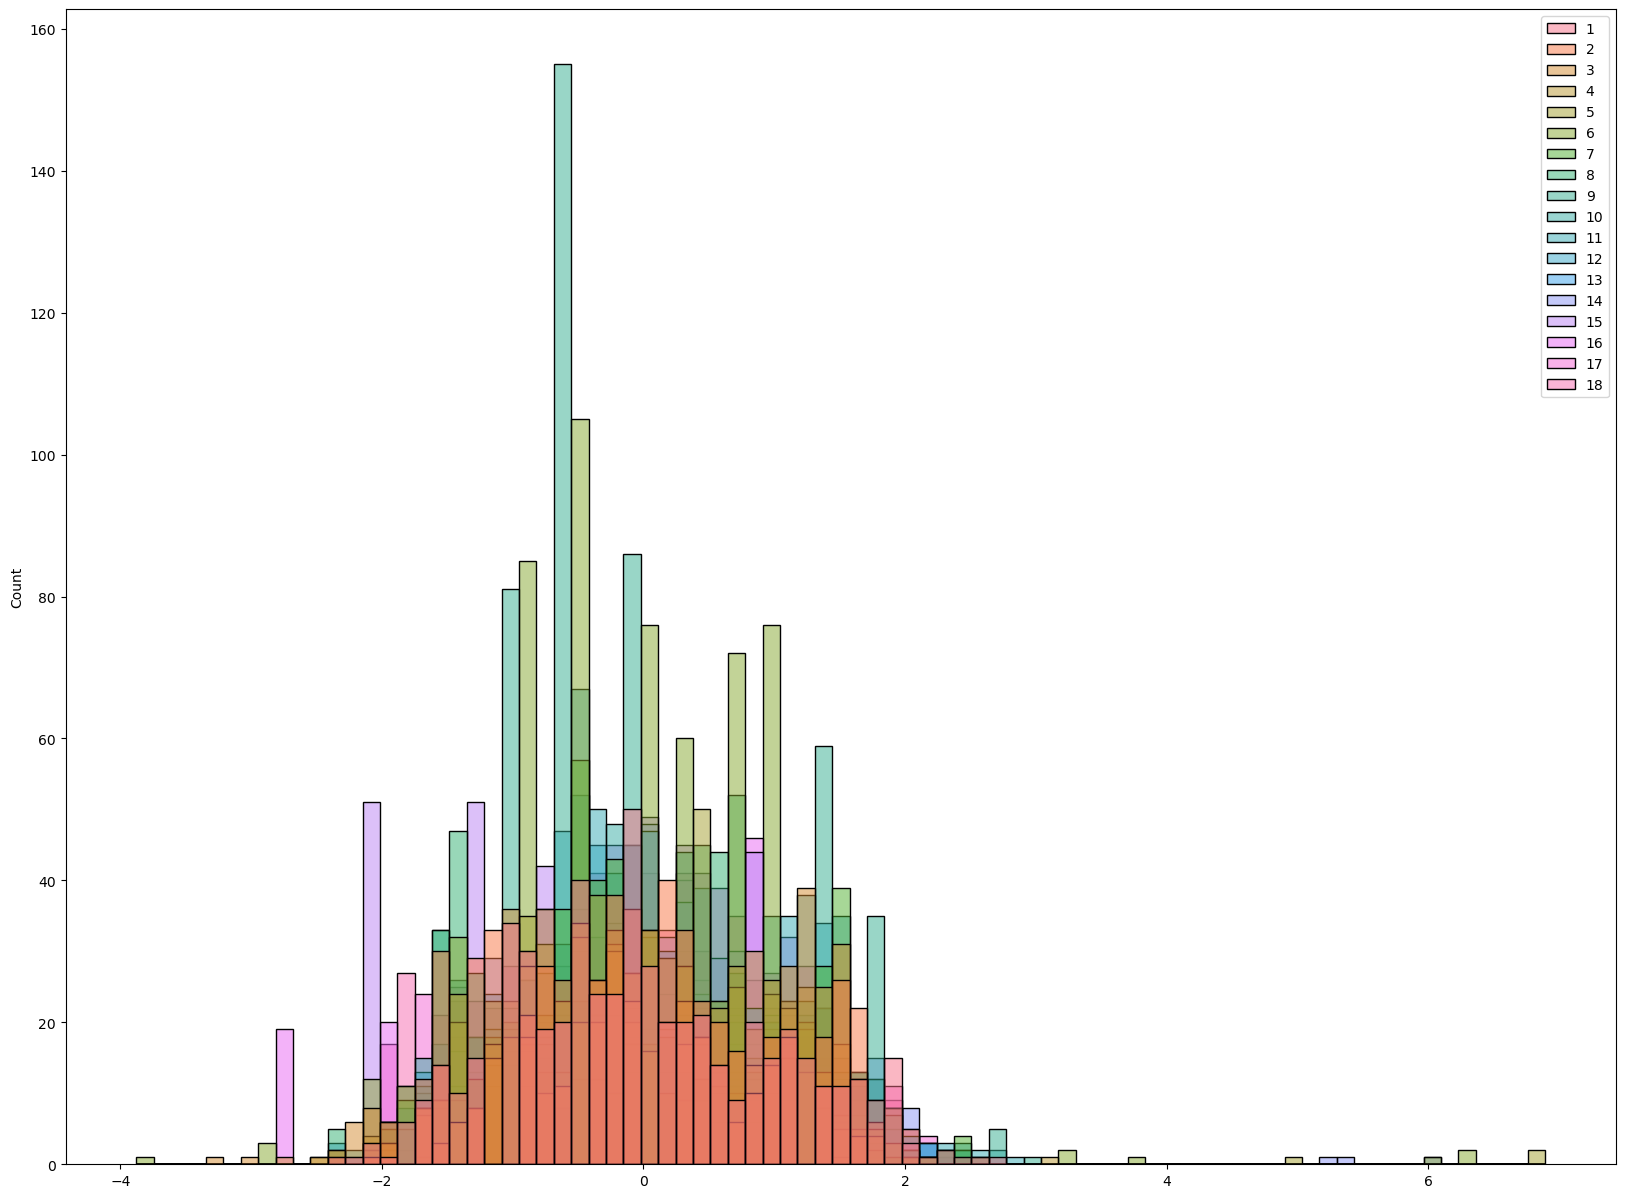

In [29]:
# Инициализируем объект класса скалеров
st_scal = StandardScaler()

# Отскалируем X_train/X_test
X_train_sc = st_scal.fit_transform(X_train)
X_test_sc = st_scal.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

# Посмотрим на распределения на примере трейна
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
sns.histplot(data=X_train_sc, ax=axes)
plt.show()

> Можно видеть, что признаки привидены к +/- одному масштабу и схожему распределению.

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [30]:
# YOUR CODE HERE
# Создадим функцию для расчета метрик
def metrics_estimation(y_test, y_pred, y_pred_proba):
    # Расчет f1_score, accuracy_score, roc_auc_score на тесте
    f1_test = np.round(f1_score(y_test, y_pred, average='macro'), 4)
    accuracy_test = np.round(accuracy_score(y_test, y_pred), 4)
    rocauc_sc = np.round(roc_auc_score(
        y_test, y_pred_proba, multi_class='ovr'), 4)

    print(f"F1 на тесте: {f1_test}")
    print(f"Accuracy на тесте: {accuracy_test}")
    print(f"ROC-score на тесте: {rocauc_sc}")

    # Построение ROC-AUC кривой для каждого класса
    n_classes = np.unique(y_test).size  # Получаем количество классов
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Цикл по каждому классу
    for i in range(n_classes):
        # Изменен индекс для бинаризации
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Построение ROC кривых
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC-кривая для класса {i} (AUC-площадь = {roc_auc[i]})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(
        'ROC-кривая для мультиклассовой классификации')
    plt.legend()
    plt.grid()
    plt.show()

F1 на тесте: 0.8022
Accuracy на тесте: 0.8081
ROC-score на тесте: 0.9564


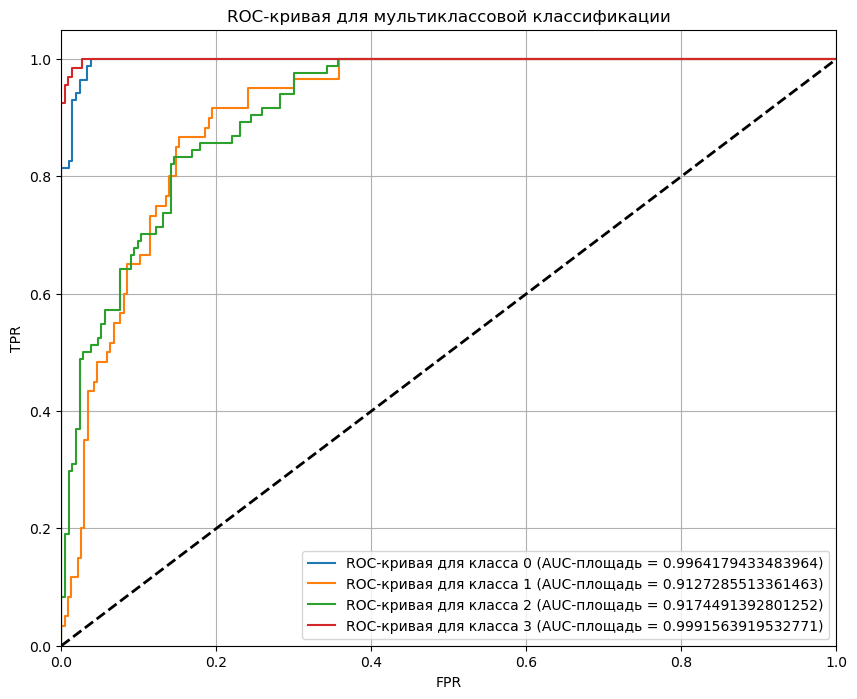

In [31]:

# Используем скорер-мейкеры для использования в
# грид-серче, используем взвешенный расчет
f1 = make_scorer(f1_score, average='weighted')
accuracy = make_scorer(accuracy_score, sample_weigh='weighted')

estimator = LogisticRegression(
    # multi_class="multinomial", # уберу для тушения ворнингов
    solver="saga",
    tol=1e-3,
    max_iter=500,
    n_jobs=-1,
    random_state=42
)

param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': [
        'elasticnet'], 'l1_ratio': [0, 0.5, 1]},
]

# Пройдемся по сетке со скорингом из двух метрик
base_log_reg = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    return_train_score=True,
    scoring=f1,
    n_jobs=-1
)

base_log_reg.fit(X_train_sc, y_train)

# Предсказания на тестовых данных
y_pred = base_log_reg.predict(X_test_sc)
y_pred_proba = base_log_reg.predict_proba(X_test_sc)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Виден дисбаланс в качестве классификации, хотя классы относительно сбалансированы.

F1 на тесте: 0.8039
Accuracy на тесте: 0.8081
ROC-score на тесте: 0.9565


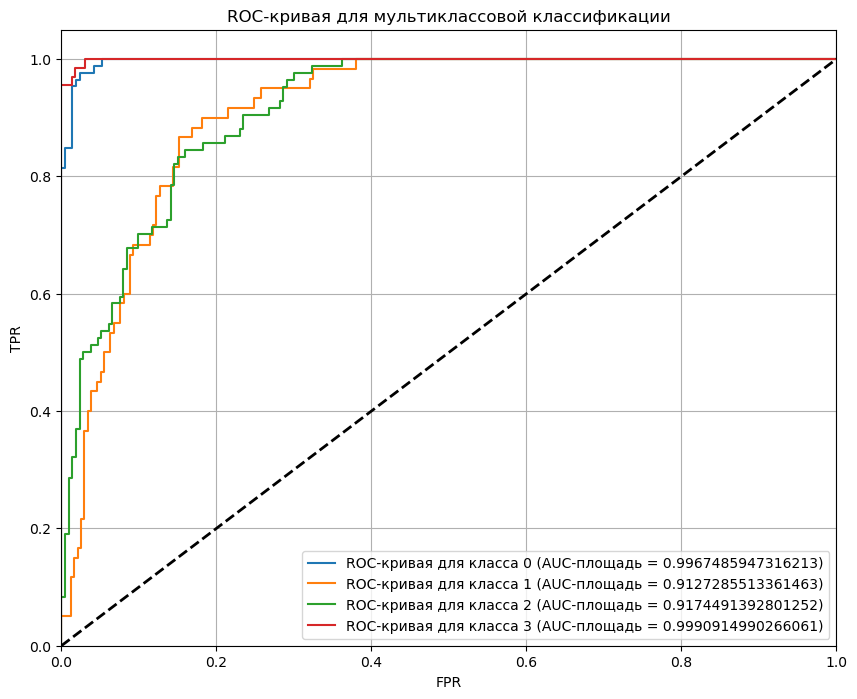

In [32]:
# грид-серче, используем взвешенный расчет
class_weights_options = [
    {0: 0.6, 1: 5, 2: 5, 3: 0.6},
    {0: 1, 1: 1, 2: 1, 3: 1},  # Равные веса для сравнения
    {0: 1, 1: 2, 2: 2, 3: 1}   # Увеличенные веса для классов 1 и 2
]
estimator = LogisticRegression(
    # multi_class="multinomial", # уберу для тушения ворнингов
    solver="saga",
    tol=1e-3,
    max_iter=4000,
    n_jobs=-1,
    random_state=42
)

# Инициализация списка параметров для сетки
param_grid = []
for class_weights in class_weights_options:
    param_grid.append({
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'class_weight': [class_weights]
    })
    param_grid.append({
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'class_weight': [class_weights]
    })
    param_grid.append({
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'l1_ratio': [0, 0.5, 1],
        'class_weight': [class_weights]
    })

# Пройдемся по сетке со скорингом из двух метрик
base_log_reg_weighted = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    return_train_score=True,
    scoring=f1,
    n_jobs=-1
)

base_log_reg_weighted.fit(X_train_sc, y_train)

# Предсказания на тестовых данных
y_pred = base_log_reg_weighted.predict(X_test_sc)
y_pred_proba = base_log_reg_weighted.predict_proba(X_test_sc)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Изменение весов классов не дало результатов

In [33]:
# You might use this command to install scikit-plot.
# Warning, if you a running locally, don't call pip from within jupyter, call it from terminal in the corresponding
# virtual environment instead

# ! pip install scikit-plot

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot. 

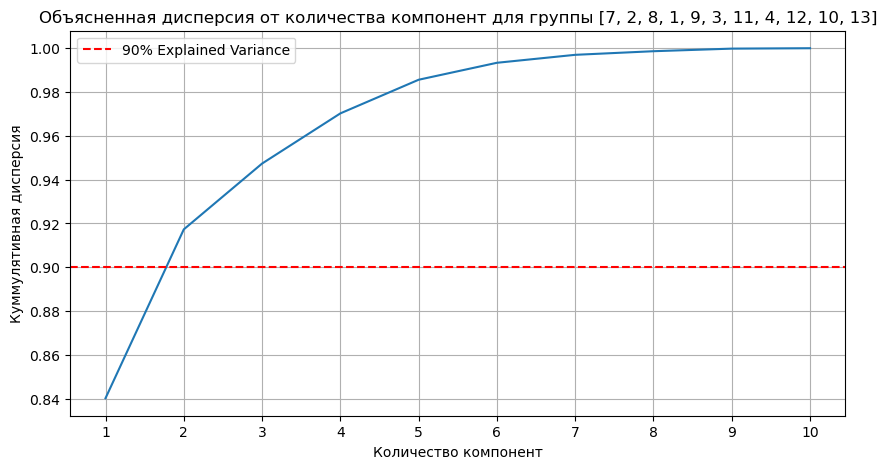

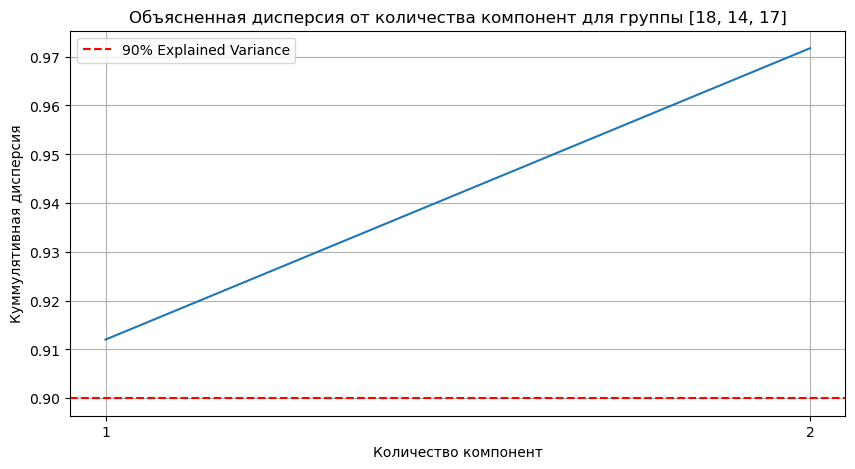

In [ ]:
# Сразу подготовим данные для дальнейших манипуляций
# Выделим колонки, которые не пойдут под трансформацию
columns_wo_pca = [i for i in groups for i in i]

# создадим субсеты для трейн/теста которые не будем трогать
X_train_wo_pca = X_train_sc.drop(columns=columns_wo_pca)
X_test_wo_pca = X_test_sc.drop(columns=columns_wo_pca)

# Выделим группы с этапа хитмапа
pca_group_1 = groups[0]
pca_group_2 = groups[1]

# На их основе создадим субсеты для PCA
X_train_pca_1 = X_train_sc[pca_group_1]
X_train_pca_2 = X_train_sc[pca_group_2]

X_test_pca_1 = X_test_sc[pca_group_1]
X_test_pca_2 = X_test_sc[pca_group_2]

##############################################


def var_visualisation(pca_group, subset):
    var_plot_data = list()

    for i in range(1, len(pca_group)):
        pca = PCA(n_components=i, random_state=42)
        pca.fit(subset)
        # var_plot_data[i] = pca.explained_variance_ratio_
        var_plot_data.append(pca.explained_variance_ratio_)

    # Подготовка данных для графика
    num_components = list(range(1, len(var_plot_data) + 1)
                          )  # Количество компонент
    # Суммарная объясненная дисперсия
    explained_variance = [sum(var) for var in var_plot_data]

    # Построение графика
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(x=num_components, y=explained_variance, ax=axes)
    plt.title(
        f'Объясненная дисперсия от количества компонент для группы {pca_group}')
    plt.xlabel('Количество компонент')
    plt.ylabel('Куммулятивная дисперсия')
    plt.xticks(num_components)  # Отображение всех значений по оси X
    plt.grid()
    plt.axhline(y=0.9, color='r', linestyle='--',
                label='90% Explained Variance')  # Отметка для 90%
    plt.legend()
    plt.show()

###############################################


var_visualisation(pca_group_1, X_train_pca_1)
var_visualisation(pca_group_2, X_train_pca_2)

In [35]:
print(X_train_pca_1.shape, X_train_pca_2.shape, X_train_wo_pca.shape)
print(X_test_pca_1.shape, X_test_pca_2.shape, X_test_wo_pca.shape)

(549, 11) (549, 3) (549, 4)
(297, 11) (297, 3) (297, 4)


> Для первой группы возьмем количество компонент равное 5, для второй группы равное 2.

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

In [36]:
# YOUR CODE HERE
# Преобразуем по отдельности группы
comp_1 = 5
pca_agent_1 = PCA(n_components=comp_1, random_state=42)
X_train_pca_1 = pca_agent_1.fit_transform(X_train_pca_1)
X_train_pca_1 = pd.DataFrame(X_train_pca_1, columns=[
                             pca_group_1[:comp_1]])  # извращение
X_test_pca_1 = pca_agent_1.transform(X_test_pca_1)
X_test_pca_1 = pd.DataFrame(X_test_pca_1, columns=[pca_group_1[:comp_1]])

comp_2 = 2
pca_agent_2 = PCA(n_components=comp_2, random_state=42)
X_train_pca_2 = pca_agent_2.fit_transform(X_train_pca_2)
X_train_pca_2 = pd.DataFrame(X_train_pca_2, columns=[
                             pca_group_2[:comp_2]])  # извращение
X_test_pca_2 = pca_agent_2.transform(X_test_pca_2)
X_test_pca_2 = pd.DataFrame(X_test_pca_2, columns=[pca_group_2[:comp_2]])

In [37]:
X_train_pca = pd.concat([X_train_wo_pca, X_train_pca_1, X_train_pca_2], axis=1)
X_test_pca = pd.concat([X_test_wo_pca, X_test_pca_1, X_test_pca_2], axis=1)

display(X_train_pca.head(), X_test_pca.head())

,5,6,15,16,"(7,)","(2,)","(8,)","(1,)","(9,)","(18,)","(14,)"
0,0.559465,0.362406,-0.156216,-0.166534,-1.420916,-0.641069,0.847255,0.471949,0.620313,2.455206,0.238986
1,1.535419,1.286251,0.902288,0.271813,5.038435,0.417635,0.232944,0.215150,0.043283,-0.338598,-0.273297
2,0.705057,-0.423334,-0.156216,-2.785737,-1.582731,-0.117312,0.138098,0.449521,-0.538401,2.355005,0.796034
3,-0.526012,-2.078325,-2.102142,0.785328,4.797270,-0.351852,0.002832,-0.979949,-0.858754,-1.749392,0.681364
4,1.266467,-0.423334,0.681848,0.785328,0.643823,0.189079,0.142752,0.713165,-0.646014,2.018121,0.927177


,5,6,15,16,"(7,)","(2,)","(8,)","(1,)","(9,)","(18,)","(14,)"
0,1.667143,-0.893529,0.412052,-2.785737,-1.261057,1.018617,-1.077089,0.850267,-0.285889,-1.344640,-0.370520
1,-1.564323,-0.008593,0.902288,-0.166534,-3.171996,0.003733,1.169747,-0.471234,0.031182,-1.979662,-0.096436
2,-1.031255,-0.423334,-2.102142,0.519329,-1.806096,0.831697,0.011271,-0.725530,-0.596368,-2.503941,-0.153142
3,0.109076,-0.893529,1.392524,0.360153,-1.603256,0.251152,-0.039781,0.264362,0.255281,-1.075517,-0.286689
4,-0.859894,-0.423334,-0.426013,0.442396,-1.381845,1.758968,-0.961290,-0.144156,0.118433,-2.338192,-0.103641


**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

F1 на тесте: 0.6941
Accuracy на тесте: 0.7071
ROC-score на тесте: 0.9174


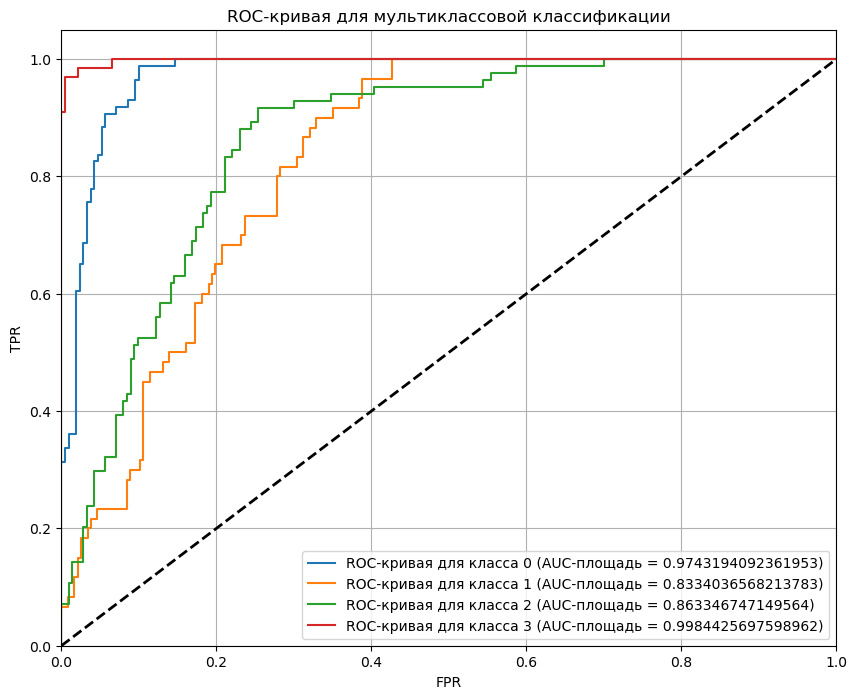

In [38]:
# YOUR CODE HERE

estimator = LogisticRegression(
    # multi_class="multinomial", # уберу для тушения ворнингов
    solver="saga",
    tol=1e-3,
    max_iter=500,
    n_jobs=-1
)

param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': [
        'elasticnet'], 'l1_ratio': [0, 0.5, 1]},
]

# Пройдемся по сетке со скорингом из двух метрик
pca_log_reg = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    return_train_score=True,
    scoring=f1,
    refit=True,
    n_jobs=-1
)

pca_log_reg.fit(X_train_pca, y_train)

# Предсказания на тестовых данных
y_pred = pca_log_reg.predict(X_test_pca)
y_pred_proba = pca_log_reg.predict_proba(X_test_pca)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Стало хуже, следовательно в дальнейших изысканиях буду использовать скалированное но не сжатое пространство признаков.

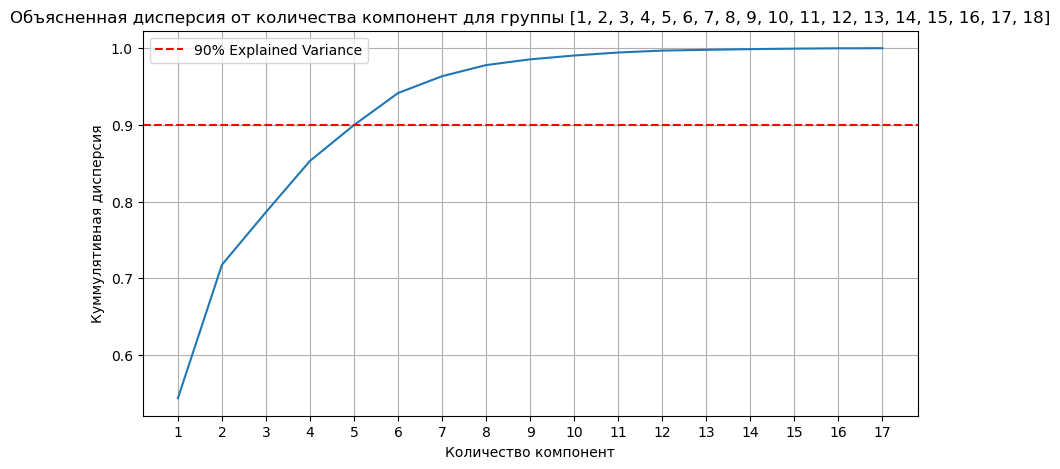

In [39]:
# Попробуем накинуть PCA на весь датасет

pca_group_whole = X_train_sc.columns.to_list()

var_visualisation(pca_group_whole, X_train_sc)

> Возьмем 16 компонент

In [40]:
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

F1 на тесте: 0.8059
Accuracy на тесте: 0.8114
ROC-score на тесте: 0.9566


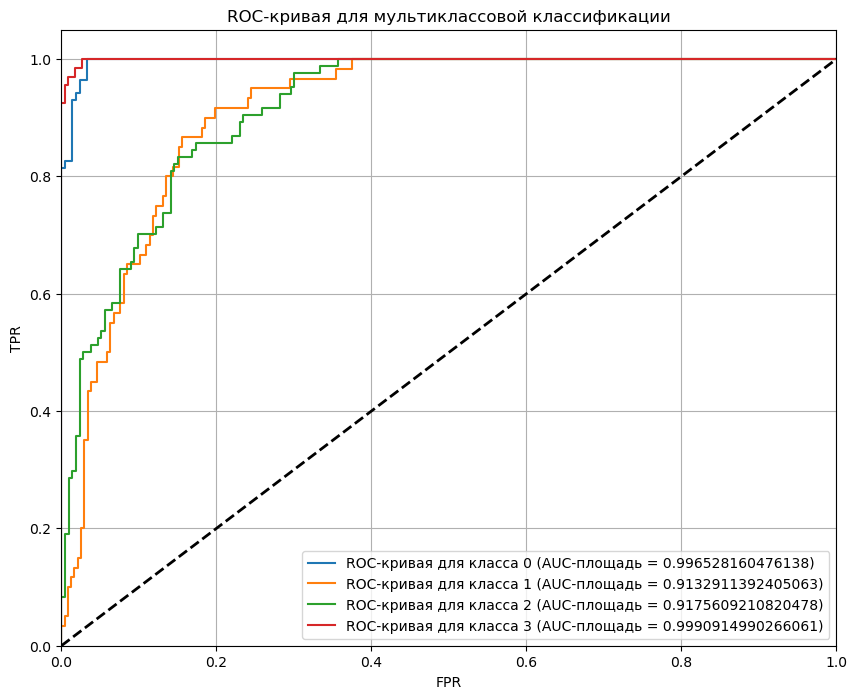

In [41]:
# YOUR CODE HERE
estimator = LogisticRegression(
    # multi_class="multinomial", # уберу для тушения ворнингов
    solver="saga",
    tol=1e-3,
    max_iter=1000,
    n_jobs=-1
)

param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': [
        'elasticnet'], 'l1_ratio': [0, 0.5, 1]},
]

# Пройдемся по сетке со скорингом из двух метрик
pca_log_reg = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    return_train_score=True,
    scoring=f1,
    refit=True,
    n_jobs=-1
)

pca_log_reg.fit(X_train_pca, y_train)

# Предсказания на тестовых данных
y_pred = pca_log_reg.predict(X_test_pca)
y_pred_proba = pca_log_reg.predict_proba(X_test_pca)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Накинув PCA на весь датасет и увеличив количество иттераций мы получили лучший результат на данный момент.

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

F1 на тесте: 0.6857
Accuracy на тесте: 0.6902
ROC-score на тесте: 0.7976


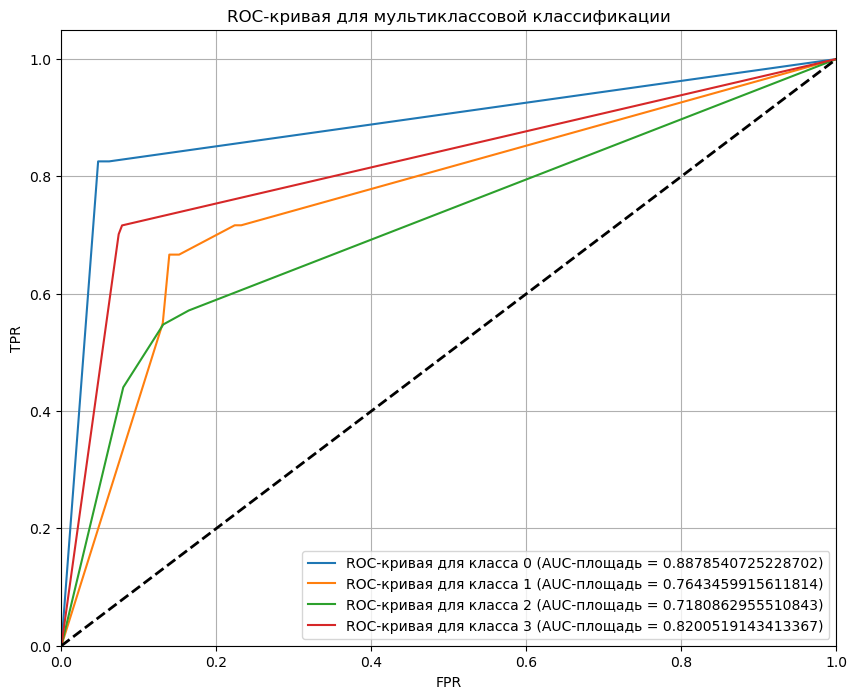

In [42]:
from sklearn.tree import DecisionTreeClassifier

# YOUR CODE HERE
# YOUR CODE HERE
# Скопируем старый код
# Используем скорер-мейкеры для использования в
# грид-серче, используем взвешенный расчет
f1 = make_scorer(f1_score, average='macro')
accuracy = make_scorer(accuracy_score, sample_weigh='weighted')

estimator = DecisionTreeClassifier(
    random_state=42
)

# Определяем параметры для поиска
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Пройдемся по сетке со скорингом из двух метрик
scaled_tree = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    return_train_score=True,
    scoring=f1,
    refit=True,
    n_jobs=-1
)

scaled_tree.fit(X_train_pca, y_train)

# Предсказания на тестовых данных
y_pred = scaled_tree.predict(X_test_pca)
y_pred_proba = scaled_tree.predict_proba(X_test_pca)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Результат хуже чем PCA на датасете под логрегом.

#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble? 

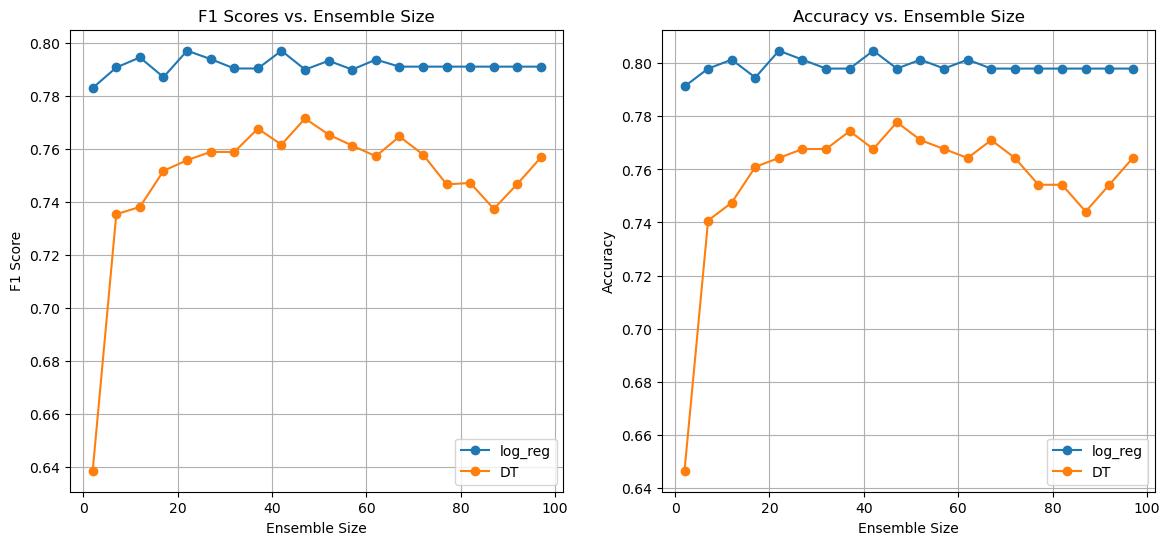

In [45]:
# YOUR CODE HERE
N_min = 2
N_max = 100
step = 5
ensemble_sizes = list(range(N_min, N_max + 1, step))
f1_scores_logreg = []
f1_scores_tree = []
accuracy_scores_logreg = []
accuracy_scores_tree = []

for N in ensemble_sizes:
    # Bagging для логистической регрессии
    logreg_bagging = BaggingClassifier(estimator=LogisticRegression(),
                                       n_estimators=N,
                                       random_state=42)
    logreg_bagging.fit(X_train_pca, y_train)
    y_pred_logreg = logreg_bagging.predict(X_test_pca)
    # Используем f1_score напрямую
    f1_scores_logreg.append(f1_score(y_test, y_pred_logreg, average='macro'))
    # Используем accuracy_score напрямую
    accuracy_scores_logreg.append(accuracy_score(y_test, y_pred_logreg))

    # Bagging для деревьев решений
    tree_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                     n_estimators=N,
                                     random_state=42)
    tree_bagging.fit(X_train_pca, y_train)
    y_pred_tree = tree_bagging.predict(X_test_pca)
    # Используем f1_score напрямую
    f1_scores_tree.append(f1_score(y_test, y_pred_tree, average='macro'))
    # Используем accuracy_score напрямую
    accuracy_scores_tree.append(accuracy_score(y_test, y_pred_tree))

# Построение графиков остается без изменений
plt.figure(figsize=(14, 6))

# График F1-меры
plt.subplot(1, 2, 1)
plt.plot(ensemble_sizes, f1_scores_logreg,
         label='log_reg', marker='o')
plt.plot(ensemble_sizes, f1_scores_tree, label='DT', marker='o')
plt.title('F1 Scores vs. Ensemble Size')
plt.xlabel('Ensemble Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()

# График точности
plt.subplot(1, 2, 2)
plt.plot(ensemble_sizes, accuracy_scores_logreg,
         label='log_reg', marker='o')
plt.plot(ensemble_sizes, accuracy_scores_tree,
         label='DT', marker='o')
plt.title('Accuracy vs. Ensemble Size')
plt.xlabel('Ensemble Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

> Лучший результат логрег на ансамбле в 41-43 моделей.

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

F1 на тесте: 0.7594
Accuracy на тесте: 0.771
ROC-score на тесте: 0.952


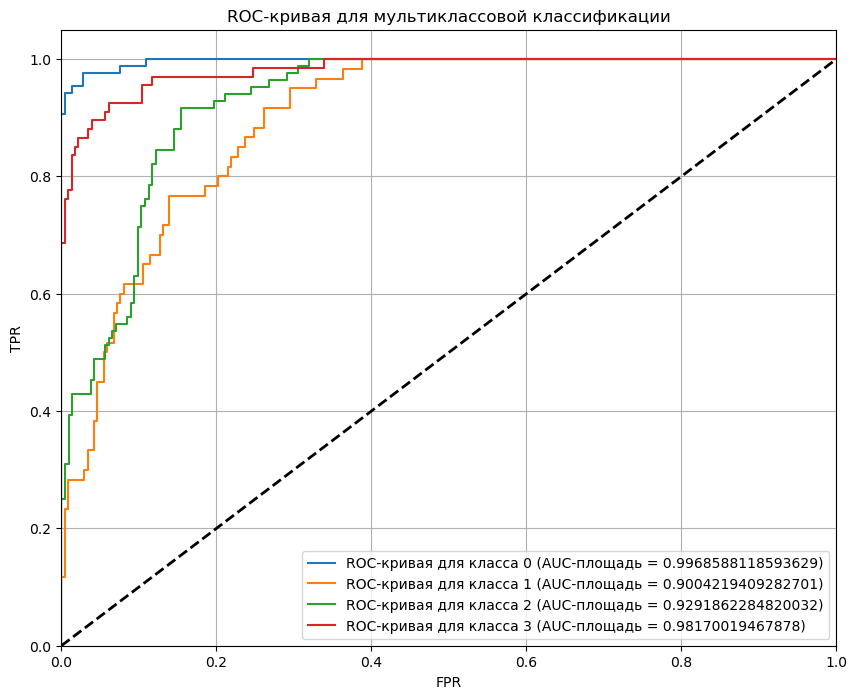

In [46]:
# YOUR CODE HERE
# Скопируем старый код
# Используем скорер-мейкеры для использования в
# грид-серче, используем взвешенный расчет
f1 = make_scorer(f1_score, average='macro')
accuracy = make_scorer(accuracy_score)

estimator = RandomForestClassifier(
    random_state=42
)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Создание скореров для нескольких метрик
scoring = {
    'f1': f1,
    'accuracy': accuracy
}

# Настройка RandomizedSearchCV
scaled_forest = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    return_train_score=True,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
)

scaled_forest.fit(X_train_pca, y_train)

# Предсказания на тестовых данных
y_pred = scaled_forest.predict(X_test_pca)
y_pred_proba = scaled_forest.predict_proba(X_test_pca)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

> Метрики уступают log_reg на X_whole_pca

---

### Создадим пайплайны лучших моделей

In [47]:
# Опять разведем таргет и фиты для логарифмирования
X = data.drop(columns=['target'])
y = data['target']

# Разбиваем на тренинговый и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

In [ ]:
n_components = 16
# Создаем Pipeline log-rega
log_reg_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('log_reg_pca', pca_log_reg)
])

# Pipe для дерева
dt_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('best_tree', scaled_tree)
])

# Pipe для беггинга
bag_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('bag', BaggingClassifier(
        estimator=LogisticRegression(),
        n_estimators=43,
        random_state=42))
])

# Pipe для леса
forest_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('rfc', scaled_forest)
])

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it? 

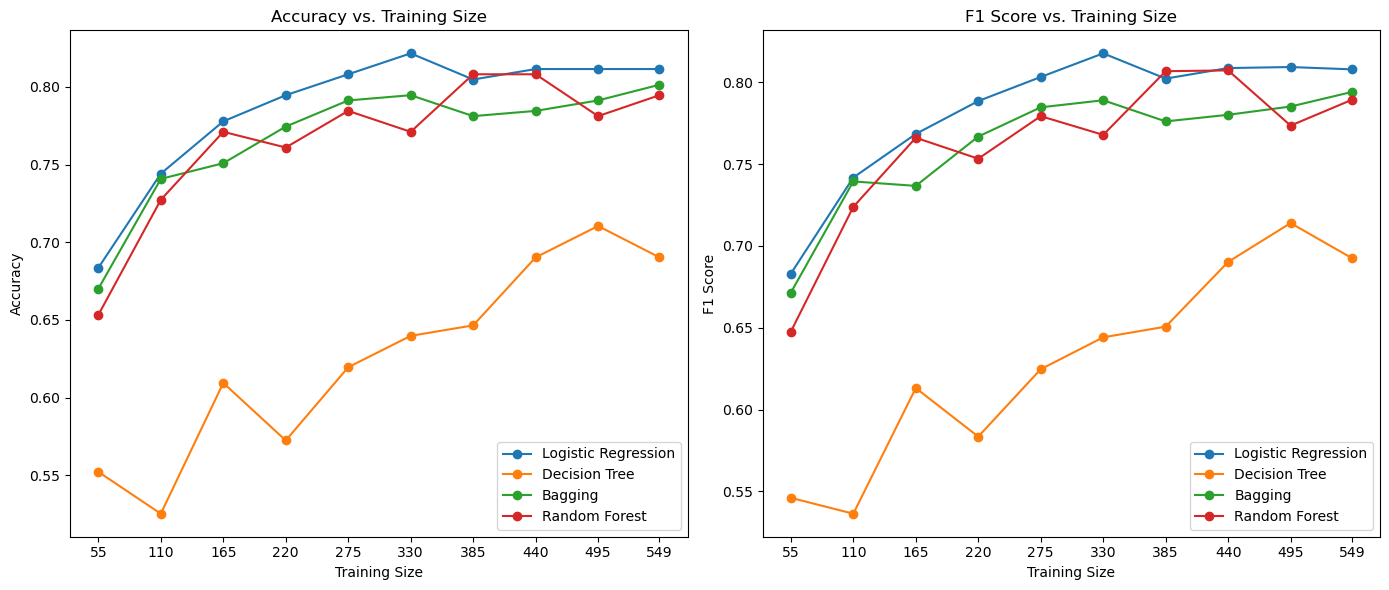

In [49]:
# YOUR CODE HERE
# Разделяем X_train и y_train на 10 частей
X_train_split = np.array_split(X_train, 10)
y_train_split = np.array_split(y_train, 10)

# Модели
models = {
    'Logistic Regression': log_reg_pipe,
    'Decision Tree': dt_pipe,
    'Bagging': bag_pipe,
    'Random Forest': forest_pipe
}

# Хранение метрик
results = {key: {'accuracy': [], 'f1': []} for key in models.keys()}

# Обучение моделей и расчет метрик с увеличением размера тренировочного набора
for i in range(1, 11):  # от 1 до 10
    X_train_subset = pd.concat(X_train_split[:i])
    y_train_subset = pd.concat(y_train_split[:i])

    for model_name, model in models.items():
        model.fit(X_train_subset, y_train_subset)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[model_name]['accuracy'].append(accuracy)
        results[model_name]['f1'].append(f1)

# Построение графиков
train_sizes = [len(pd.concat(X_train_split[:i])) for i in range(1, 11)]

plt.figure(figsize=(14, 6))

# График для Accuracy
plt.subplot(1, 2, 1)
for model_name, metrics in results.items():
    plt.plot(train_sizes, metrics['accuracy'], marker='o', label=model_name)
plt.title('Accuracy vs. Training Size')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.xticks(train_sizes)
plt.legend()

# График для F1 Score
plt.subplot(1, 2, 2)
for model_name, metrics in results.items():
    plt.plot(train_sizes, metrics['f1'], marker='o', label=model_name)
plt.title('F1 Score vs. Training Size')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.xticks(train_sizes)
plt.legend()

plt.tight_layout()
plt.show()

> По данным графиков, можно отметить, что в данном случае качество предсказаний начинает падать на определенном моменте увеличения тренировочной выборки (в случае с логистической регрессией и случайным лесом, но не деревом-оно ведет себя предсказуемо), что может сказать о наличии и влиянии выбросов к которым не чувствительно дерево.

---

### Бонус, проверка отсутсвия утечек на этапе экспериментов плюс попытка понять причины низкой метрики.

In [52]:
# Функция для отсечения выбросов
def outliers_z_score(data, feature, left_mod=3, right_mod=3, log_scale=False):

    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]

    mu = x.mean()

    sigma = x.std()

    lower_bound = mu - left_mod * sigma

    upper_bound = mu + right_mod * sigma

    outliers = data[(x < lower_bound) | (x > upper_bound)]

    cleaned = data[(x > lower_bound) & (x < upper_bound)]

    return  cleaned

### Реинициализируем датасет

In [75]:
dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

# Преобразуем датасет к датафрейму
data_df = pd.DataFrame(data)
target_df = pd.DataFrame(target)

data_df = data_df.drop(columns=0)

# Закодируем таргет
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target_df)
y_target = pd.DataFrame(y, columns=["target"])

(846, 19) (846,)


In [76]:
# Склеим датасет для очистки выбросов
data = pd.concat([data_df, y_target], axis=1)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,target
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,0


### Очистим от выбросов 3-мя сигмами

In [77]:
data = outliers_z_score(data, feature=3)
data = outliers_z_score(data, feature=4)
data = outliers_z_score(data, feature=5)
data = outliers_z_score(data, feature=6)
data = outliers_z_score(data, feature=14)
data = outliers_z_score(data, feature=15)
data = outliers_z_score(data, feature=16)

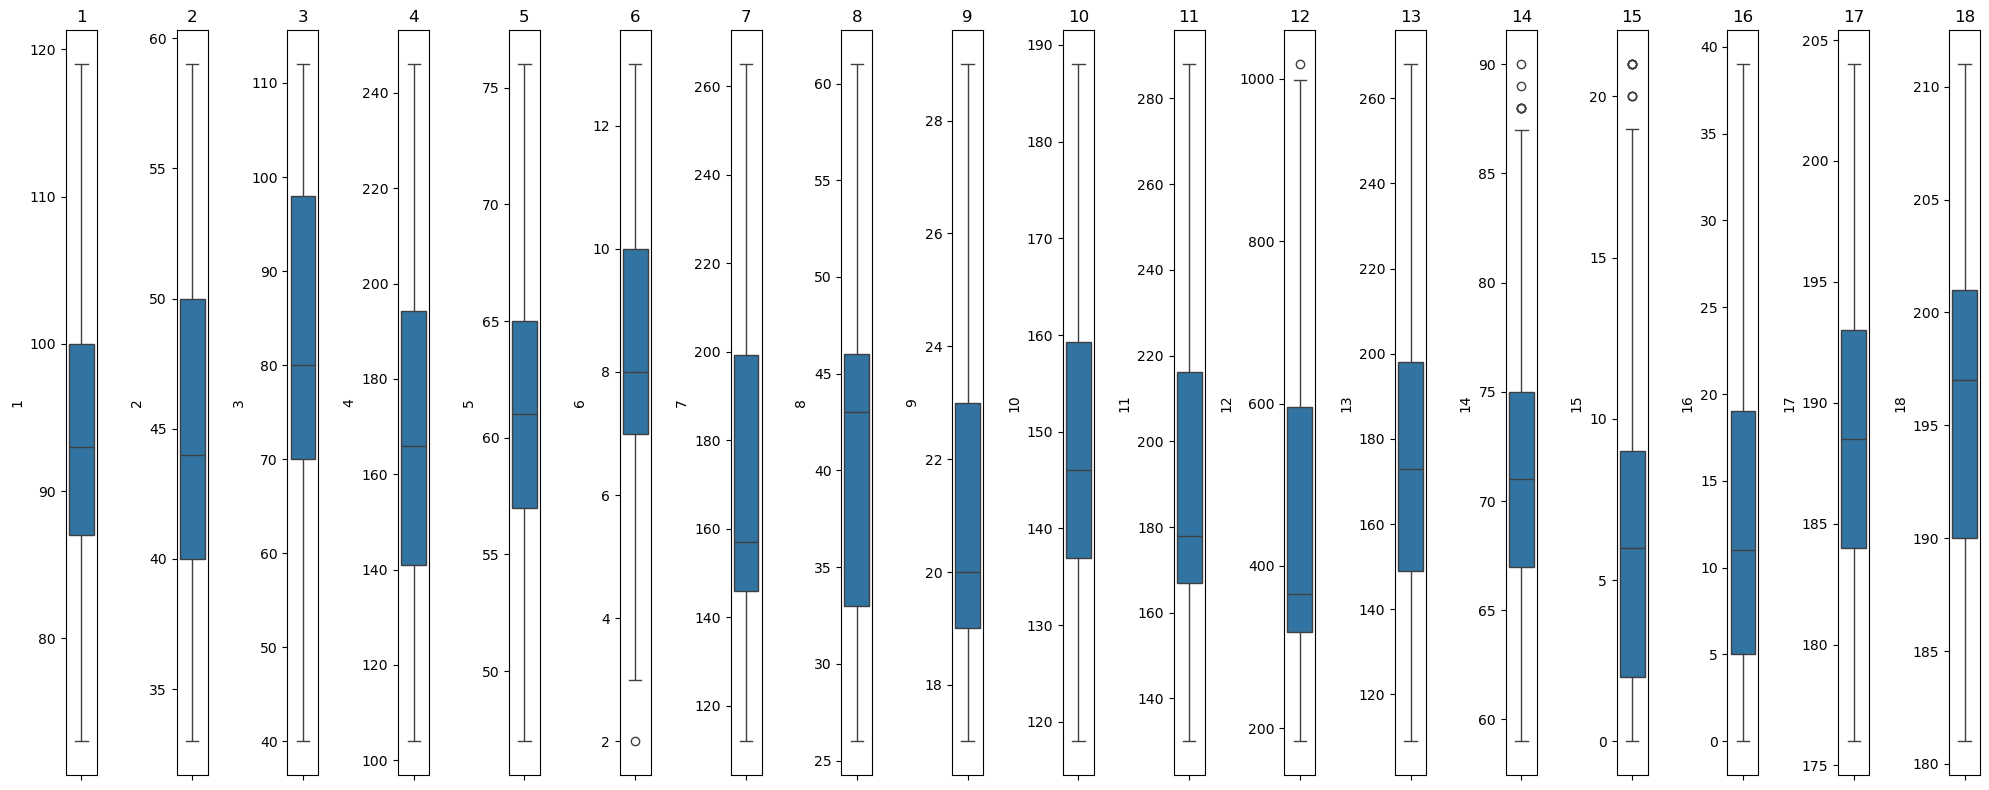

In [78]:
# Создание подграфиков
fig, axes = plt.subplots(1, num_columns, figsize=(20, 8))

# Обход всех колонок и построение боксплота для каждой из них
for i, column in enumerate(data.columns[:-1]):
    sns.boxplot(data=data[column], ax=axes[i])
    axes[i].set_title(column)

# Отображение графиков
plt.tight_layout()
plt.show()

In [83]:
# Опять разведем таргет и фиты для логарифмирования
X = data.drop(columns=['target'])
y = data['target']

# Разбиваем на тренинговый и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.45, random_state=42)

In [ ]:
# Пересоздадим пайплайны и для устойчивости укажем лучшие имплементации моделей
n_components = 16
# Создаем Pipeline log-rega
log_reg_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('log_reg_pca', LogisticRegression(
        C=100, penalty='l2',
        max_iter=1000, n_jobs=-1, 
        solver='saga', tol=0.001, 
        random_state=42
        ))
])

# Pipe для дерева
dt_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('best_tree', DecisionTreeClassifier(
        class_weight= 'balanced',
        criterion= 'gini',
        max_depth= None,
        max_features= None,
        min_samples_leaf= 1,
        min_samples_split= 2,
        random_state=42))
])

# Pipe для беггинга
bag_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('bag', BaggingClassifier(
        estimator=LogisticRegression(),
        n_estimators=43,
        random_state=42))
])

# Pipe для леса
forest_pipe = Pipeline([
    ('log_transformer', LogTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('rfc', RandomForestClassifier(
        criterion='entropy', max_depth=15, 
        min_samples_leaf=2, n_estimators=200, 
        random_state=42))
])

F1 на тесте: 0.8183
Accuracy на тесте: 0.8177
ROC-score на тесте: 0.955


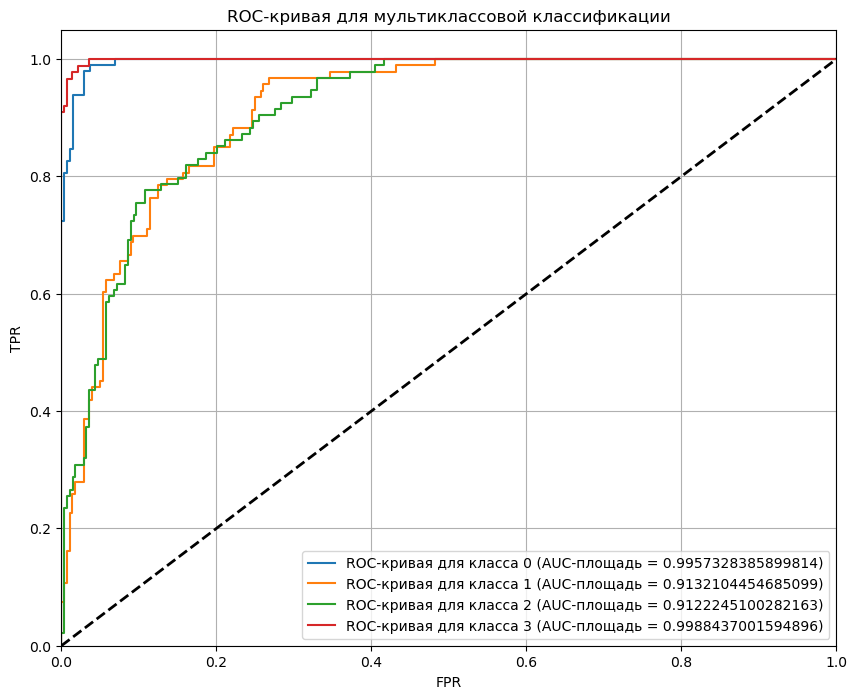

In [84]:
# Посмотрим как отработают наши пайпы
# log-reg с PCA
log_reg_pipe.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = log_reg_pipe.predict(X_test)
y_pred_proba = log_reg_pipe.predict_proba(X_test)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

F1 на тесте: 0.6709
Accuracy на тесте: 0.6729
ROC-score на тесте: 0.7817


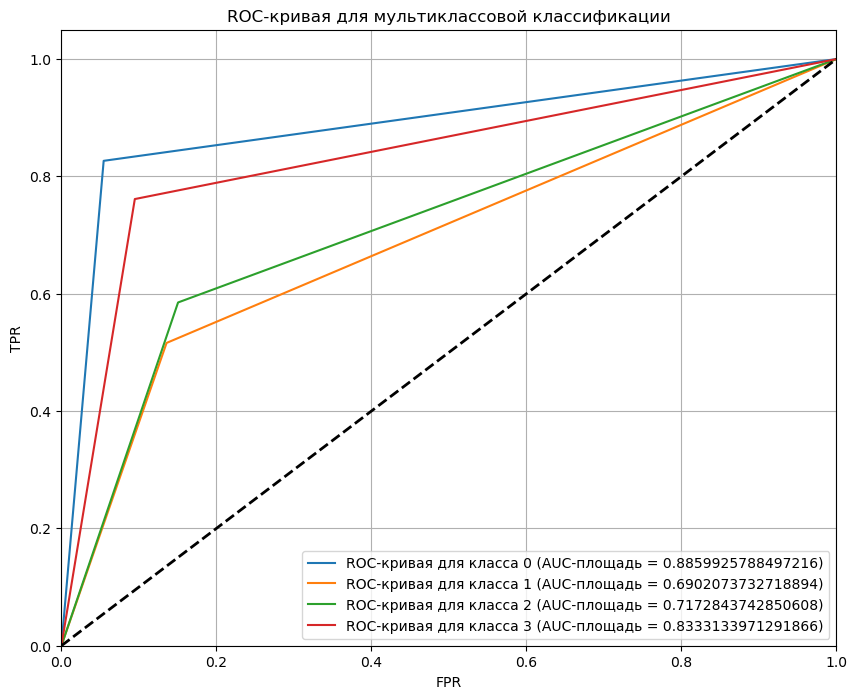

In [85]:
# дерево
dt_pipe.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = dt_pipe.predict(X_test)
y_pred_proba = dt_pipe.predict_proba(X_test)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

F1 на тесте: 0.8071
Accuracy на тесте: 0.807
ROC-score на тесте: 0.9495


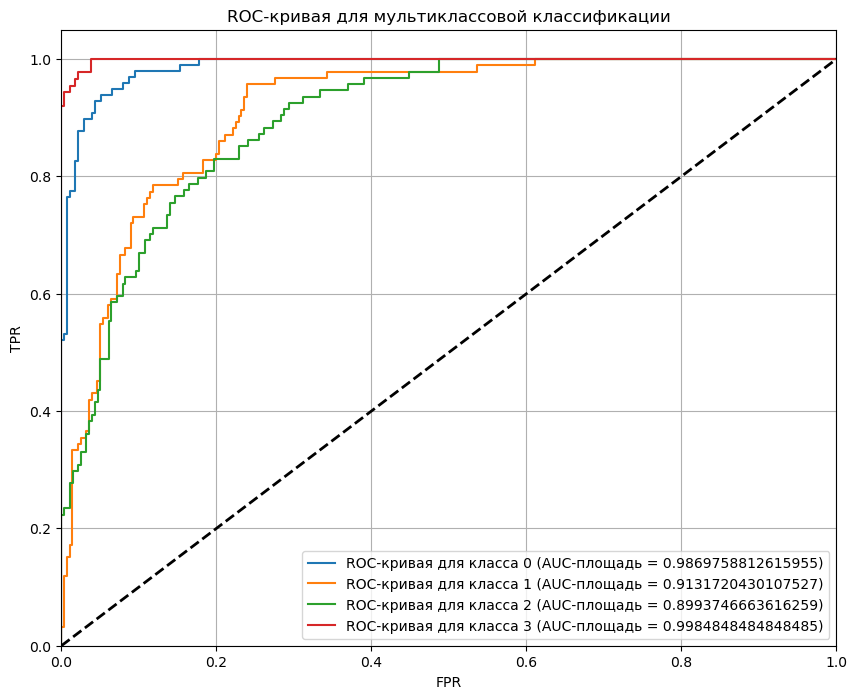

In [86]:
# бэггинг
bag_pipe.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = bag_pipe.predict(X_test)
y_pred_proba = bag_pipe.predict_proba(X_test)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)

F1 на тесте: 0.815
Accuracy на тесте: 0.8177
ROC-score на тесте: 0.9514


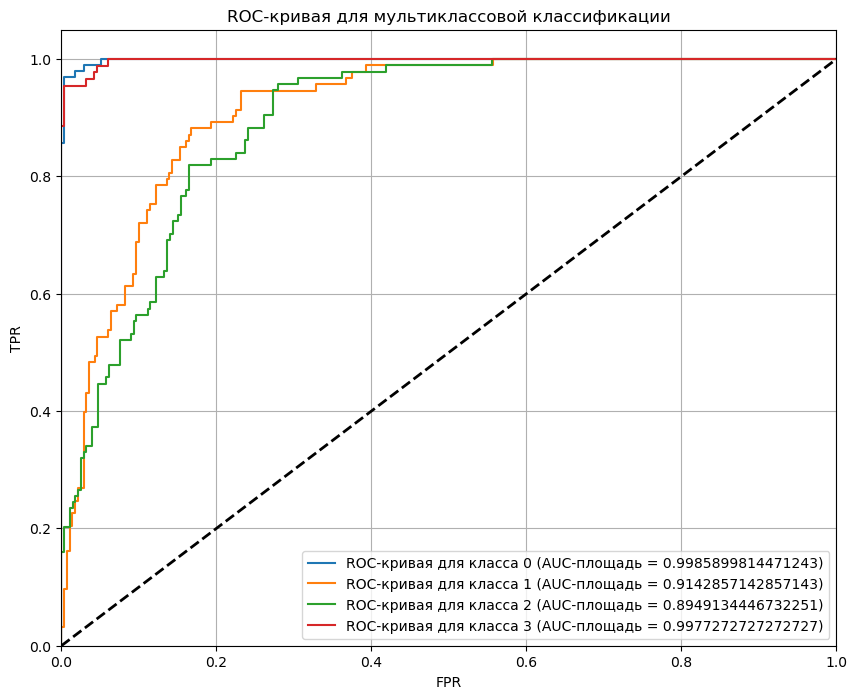

F1 на тесте: 1.0
Accuracy на тесте: 1.0
ROC-score на тесте: 1.0


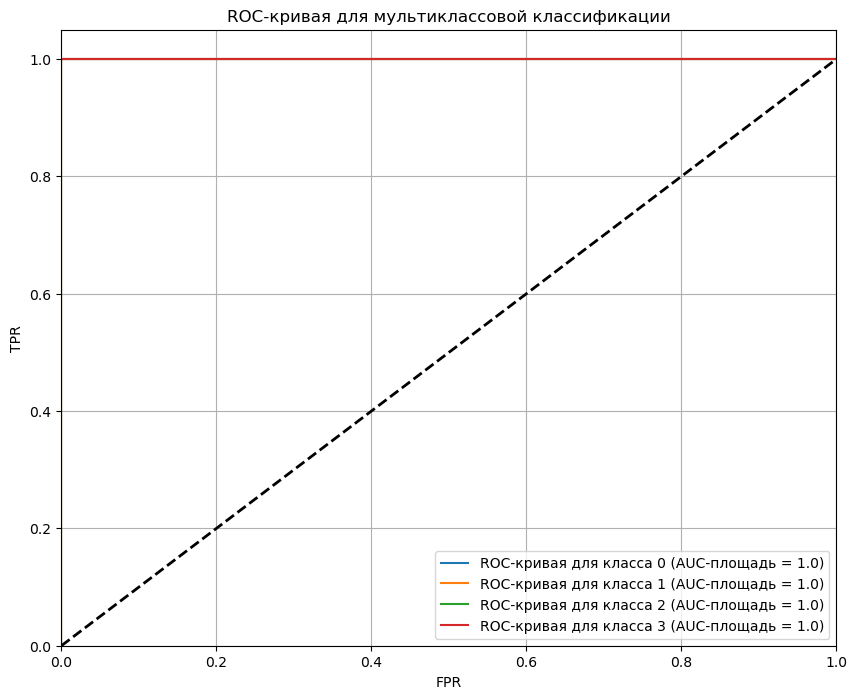

In [90]:
# лес
forest_pipe.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = forest_pipe.predict(X_test)
y_pred_proba = forest_pipe.predict_proba(X_test)

y_pred_train = forest_pipe.predict(X_train)
y_pred_proba_train = forest_pipe.predict_proba(X_train)

# Расчитаем метрики на пожобранных параметрах
metrics_estimation(y_test, y_pred, y_pred_proba)
metrics_estimation(y_train, y_pred_train, y_pred_proba_train)

> Пайплайн работает как надо, утечек нет, но есть нюанс!

> Модель переобучилась, и это ответ на то, почему на последнем задании с увеличением тренировочной выборки метрика с определенного момента начала падать. Скорее всего причина кроется в недостаточной подготовке данных. Попробуем это исправить.